In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from gensim.models import Word2Vec

# Chargement des données
Les données sont partagées parmi plusieurs fichiers distincts. L'énoncé nous indique qu'on doit se servir uniquement des fichiers `orders_distance_stores_softmax` et `order_products__prior_specials`, mais il peut être pertinent pour l'analyse d'avoir accès à des informations de base sur les produits tels que le nom et le département de ceux-ci. Nous chargeons donc dans un premier temps tous les fichiers et les concaténons dans un tableau unique.

In [2]:
# Les produits, départements et allées ("aisles")
product_df = pd.read_csv("./data/products.csv")
aisles_df = pd.read_csv("./data/aisles.csv")
deparments_df = pd.read_csv("./data/departments.csv")
# Fusion des trois tableaux sur les clés primaires
products_df = product_df.merge(deparments_df, on="department_id", how="left")
products_df = products_df.merge(aisles_df, on="aisle_id", how="left")

# Informations sur les commandes ("orders")
dist_store_df = pd.read_csv("./data/orders_distance_stores_softmax.csv")
dist_store_df = dist_store_df.drop("Unnamed: 0", axis=1)
prod_prior_df = pd.read_csv("./data/order_products__prior_specials.csv")
prod_prior_df = prod_prior_df.drop("Unnamed: 0", axis=1)
orders_df = prod_prior_df.merge(dist_store_df, on="order_id")
#orders_df = orders_df.merge(products_df, on="product_id", how="left")

# Chargement des modèles Word2Vec
store_model = Word2Vec.load("./models/store_products.model")
product_model = Word2Vec.load("./models/products.model")
user_model = Word2Vec.load("./models/user_products.model")

# Preprocessing
## Données invalides
Avant de s'attaquer à une sélection astucieuse des données, on peut déjà évacuer les données invalides si elles existent.

In [3]:
# Columns with unique values
uniq_cols = list(orders_df.columns[orders_df.nunique() == 1])

# Columns with invalid values
nan_cols = list(orders_df.columns[orders_df.isna().any()])

print("Unique columns: {}".format(uniq_cols))
print("NaN columns: {}".format(nan_cols))

# NaN values days_since_prior_order come from items bought twice on the same day.
# Replace the values with with zeros
orders_df["days_since_prior_order"] = orders_df["days_since_prior_order"].fillna(0)
# Remove columns with unique values
orders_df = orders_df.drop(uniq_cols, axis=1)

assert len(list(orders_df.columns[orders_df.nunique() == 1])) == 0, "There are still columns with unique values"
assert len(list(orders_df.columns[orders_df.isna().any()])) == 0, "There are still columns with NaN values"

Unique columns: ['eval_set']
NaN columns: ['days_since_prior_order']


In [4]:
n_products = orders_df["product_id"].nunique()
n_stores = orders_df["store_id"].nunique()
n_users = orders_df["user_id"].nunique()
n_orders = orders_df["order_id"].nunique()
n_departments = products_df["department_id"].nunique()
n_aisles = products_df["aisle_id"].nunique()
n_target_rows = int(len(orders_df) * 0.05)

print("Target number of rows: %d" % n_target_rows)
print("Current number of rows: %d" % len(orders_df))
print("Number of rows to remove: %d" % (len(orders_df) - n_target_rows))
basic_info_df = pd.DataFrame(
    [[n_products, n_departments, n_aisles, n_stores, n_users, n_orders]],
    columns=["# Products", "# Departments", "# Aisles", "# Stores", "# Users", "# Orders"]
)
basic_info_df

Target number of rows: 58615
Current number of rows: 1172312
Number of rows to remove: 1113697


,# Products,# Departments,# Aisles,# Stores,# Users,# Orders
0,24860,21,134,10,1374,136026


1    0.774435
0    0.225565
Name: reordered, dtype: float64


<AxesSubplot:>

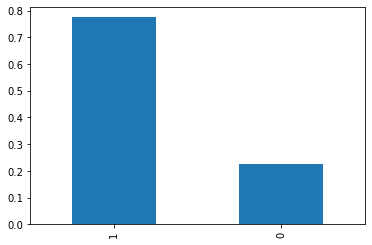

In [5]:
# Distribution des classes
print((orders_df["reordered"].value_counts() / len(orders_df)))
(orders_df["reordered"].value_counts() / len(orders_df)).plot.bar()

On constate un débalancement assez sévère des classes. On compte 907 879 (77.4435%) et 264 433 (22.5565%) commandes avec respectivement "reordered=True" et "reordered=False". Autrement dit, les commandes avec produits achetés à plusieurs reprises sont 3.43 fois plus nombreuses que les commandes avec des produits nouveaux. Notre sous-échantillonnage doit prendre en compte ce débalancement pour éviter de perdre trop d'instances "reordered=False".

Commençons par supprimer les instances aberrantes, c'est-à-dire:
- les clients avec peu de commandes différentes;
- les produits achetés par peu de clients différents;
- les produits présents dans peu de commandes différentes;

In [6]:
# Fonction utilitaire permettant de simuler une requête d'aggrégation SQL du genre
# SELECT col, COUNT(DISTINCT agg_col) AS n_agg_col FROM table_name GROUP BY col, agg_col
# Les commandes équivalentes avec l'API de Pandas génèrent beaucoup de doublons, ce qui nous force
# à implémenter cette solution.  
def count_distinct(dataframe, groupby_col, count_col):
    d = defaultdict()
    for row in dataframe.itertuples():
        uid = getattr(row, groupby_col)
        d[uid] = set()

    for row in dataframe.itertuples():
        uid = getattr(row, groupby_col)
        count_attr = getattr(row, count_col)
        d[uid].add(count_attr)

    df_count_col_name = "%s_count" % count_col
    d = {groupby_col: d.keys(), df_count_col_name: [len(v) for v in d.values()]}
    return pd.DataFrame.from_dict(d).sort_values(by=df_count_col_name)

In [7]:
users_n_order_df = count_distinct(orders_df, "user_id", "order_id")
users_n_order_df

,user_id,order_id_count
0,54901,99
920,71049,99
919,159610,99
918,190212,99
917,19612,99
...,...,...
454,150481,99
453,170217,99
452,31606,99
460,96192,99


In [8]:
products_n_order_df = count_distinct(orders_df, "product_id", "order_id")
products_n_order_df

,product_id,order_id_count
24859,17633,1
21220,36348,1
21221,19574,1
21223,29096,1
21224,33586,1
...,...,...
123,21903,9594
126,47209,10654
27,21137,13163
62,24852,16466


Le premier tableau nous informe que les données sont organisées de sorte que chaque utilisateur a exactement 99 commandes. Par conséquent, aucun consommateur ne doit être retiré. Cependant, plusieurs produits sont présents dans une unique commande. Ceux-ci peuvent potentiellement être considérés comme du bruit par nos algorithme de classification et doivent par conséquent être retirés. En ce sens, nous considérons seulement les produits se trouvant dans les 3e et 4e quartiles. Ainsi, on conserve les produits achetés à plusieurs reprises.

In [9]:
order_id_cnt_thres = products_n_order_df["order_id_count"].quantile(0.5)
n_products = products_n_order_df["product_id"].nunique()
mask = products_n_order_df["order_id_count"] < order_id_cnt_thres
to_remove = products_n_order_df[mask]["product_id"].unique()

print("Number of products: %d" % n_products)
print("Number of products to remove: %d" % len(to_remove))
print("Number of remaining products: %d" % (n_products - len(to_remove)))

n_rows_before = len(orders_df)
mask = orders_df["product_id"].isin(to_remove)
orders_df_prime = orders_df.drop(orders_df[mask].index)
n_rows_after = len(orders_df_prime)

products_n_users_df = count_distinct(orders_df_prime, "product_id", "user_id")

print("Number of rows to remove: %d" % mask.sum())
print("Number of remaining rows: %d" % n_rows_after)

user_id_cnt_thres = products_n_users_df["user_id_count"].quantile(0.25)
mask = products_n_users_df["user_id_count"] < user_id_cnt_thres
to_remove = products_n_users_df[mask]["product_id"].unique()

print("Number of products: %d" % n_products)
print("Number products to remove: %d" % len(to_remove))
print("Number of remaining products: %d" % (n_products - len(to_remove)))

n_rows_before = len(orders_df_prime)
mask = orders_df["product_id"].isin(to_remove)
orders_df_prime = orders_df_prime.drop(orders_df_prime[mask].index)
n_rows_after = len(orders_df_prime)
print("Number of rows to remove: %d" % mask.sum())
print("Number of remaining rows: %d" % n_rows_after)

Number of products: 24860
Number of products to remove: 11983
Number of remaining products: 12877
Number of rows to remove: 26086
Number of remaining rows: 1146226
Number of products: 24860
Number products to remove: 2740
Number of remaining products: 22120
Number of rows to remove: 37587
Number of remaining rows: 1108639


C:\Users\verdi\AppData\Local\Temp\ipykernel_14320\2057720334.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  orders_df_prime = orders_df_prime.drop(orders_df_prime[mask].index)


On s'assure que les modifications respectent les conditions, c'est-à-dire
- les consommateurs ont plusieurs commandes;
- les produits sont présents dans plusieurs commandes;
- les produits sont achetés par plusieurs consommateurs;

In [10]:
# Validation
users_n_order_df = count_distinct(orders_df_prime, "user_id", "order_id")
assert users_n_order_df["order_id_count"].min() >= order_id_cnt_thres, "Il reste des utilisateurs avec moins de %d commandes différentes." % order_id_cnt_thres

products_n_order_df = count_distinct(orders_df_prime, "product_id", "order_id")
assert products_n_order_df["order_id_count"].min() > user_id_cnt_thres, "Il reste des produits présents dans moins de %d commandes différentes." % user_id_cnt_thres

products_n_order_df = count_distinct(orders_df_prime, "product_id", "user_id")
assert products_n_order_df["user_id_count"].min() > 1, "Il reste des produits achetés seulement par un consommateur"

Après toutes ces opérations, les données sont réduites à 1 108 639 observations, ce qui représente environ 5% des données originales. Il reste donc 1 050 023 entrées à supprimer. Pour ce faire, nous proposons la stratégie suivante. Puisque nous avons un nombre de commandes élevé pour chacun des utilisateurs, on peut simplement conserver au plus $\tau = n\_commandes\_disponibles / n\_clients$ commandes différentes pour chacun des utilisateurs.

In [11]:
tau = int(np.ceil(n_target_rows / users_n_order_df["user_id"].nunique()))
assert users_n_order_df["order_id_count"].min() > tau, "Il existe un ou plusieurs clients avec un nombre de commandes inférieur à %d." % tau
print("Maximum number of orders per user: %d" % tau)

Maximum number of orders per user: 43


Comme tous les clients possèdent au minimum 43 commandes, cette stratégie devrait fonctionner. On doit être prudent et conserver un ratio des classes similaire dans notre procédure. Avec la loi forte des grands nombres, on sait qu'un sous-échantillonage aléatoire suffisamment grand devrait conserver le ratio original. Toutefois, pour nous en assurer, nous introduisons une procédure de type Las Vegas qui répète le sous-échantillonage jusqu'à ce le ratio soit respecté à un epsilon près. Une procédure aléatoire semble inappropriée car on cherche des paniers d'achat variés. Toutefois, considérant le faible nombre de paniers par consommateurs (99) et le nombre de paniers conservés (43), la probabilité de ne pas piger des produits variés est négligeable.

In [12]:
# On s'assure que le balancement des classes demeure le même
class_ratio_df = orders_df_prime["reordered"].value_counts() / len(orders_df_prime)
maj_cls_ratio = class_ratio_df[1]
min_cls_ratio = class_ratio_df[0]

ratio_is_respected, n_iter = False, 0
final_df = pd.DataFrame(columns=orders_df_prime.columns)
class_ratio_final_df = None

while not ratio_is_respected:
    final_df = pd.DataFrame(columns=orders_df_prime.columns)
    for tup in users_n_order_df.itertuples():
        # Masque pour filtrer l'utilisateur
        mask = orders_df_prime["user_id"] == tup.user_id
        # Échantillonnage aléatoire des commandes de l'utilisateur
        random_orders = orders_df_prime[mask].sample(tau)
        # Ajout des échantillons au tableau final
        final_df = pd.concat((final_df, random_orders))
    # Calcul du ratio des classes
    class_ratio_final_df = final_df["reordered"].value_counts() / len(final_df)
    ratio_is_respected = np.isclose(class_ratio_final_df[1], maj_cls_ratio, atol=1e-2) and np.isclose(class_ratio_final_df[0], min_cls_ratio, atol=1e-2)
    n_iter += 1

print(class_ratio_final_df)
print("Processus complété avec %d itération(s)" % n_iter)

1    0.775058
0    0.224942
Name: reordered, dtype: float64
Processus complété avec 2 itération(s)


## Conversion des variables catégoriques
Les attributs `product_id`, `user_id` et `store_id` sont initialement chargés et interprétés comme étant des valeurs numériques par nos librairies. Toutefois, ceux-ci représentent des identifiants uniques qui ne se soumettent pas à des opérations arithmétiques. Par exemple, la distance numérique entre les utilisateurs $1000$ et $1$ ($1000-1=999$) ne fait aucun sens, car on compare leur identifiant. Peut-être achètent-ils les mêmes produits et magasinent au même endroit et sont en fait beaucoup plus similaires. Par conséquent, nous empruntons une stratégie tirée des langages naturels pour convertir des mots en vecteurs permettant de représenter une notion de distances entre ceux-ci. Nous utilisons à cet effet l'algorithme `Word2Vec` offert par la librairie Gensim. Ainsi, les attributs `user_id`, `store_id` et `product_id` sont convertis en vecteurs normés de $10$ éléments chacun. Pour ce faire on génère trois tableaux de contingence: le premier associe les produits à chaque commande, le deuxième chaque utilisateur aux produits et le dernier chaque magasin à chaque produit. Finalement, on normalise les autres attributs et on se débarrasse des colonnes `user_id`, `store_id`, `product_id` et `order_id` puisqu'elles sont désormais désuettes.

In [13]:
import gensim
from sklearn.preprocessing import MinMaxScaler

def w2v_emb(df: pd.DataFrame, groupby_col: str, aggregate_col: str, n_epochs=5, embedding_size=10, num_negative_samples=7, min_count=1):
    df = df.groupby(groupby_col).apply(lambda x: x[aggregate_col].tolist())
    window_size = np.max(df.apply(len))

    # Entraînement du modèle
    return gensim.models.Word2Vec(
        sentences=df,
        sg=1, # 1 for skip-gram
        vector_size=embedding_size,
        window=window_size,
        min_count=min_count,
        workers=4,
        hs=0, # negative sampling will be used.
        negative=num_negative_samples,
        ns_exponent=0, # The exponent used to shape the negative sampling distribution.
        epochs=n_epochs
    )

def add_embeddings(df: pd.DataFrame, w2v_model: Word2Vec, key: str):
    embeddings = []
    for row in df.itertuples():
        val = getattr(row, key)
        embed = w2v_model.wv.get_vector(val, norm=True)
        embeddings.append(embed)
    return np.array(embeddings)

def concat_df_cols(original_df: pd.DataFrame, to_add: np.ndarray, suffix: str):
    assert to_add.ndim == 2, "to_add must have exactly 2 dimensions"
    to_add_df = pd.DataFrame(to_add, columns=["%s%d" % (suffix, i) for i in range(to_add.shape[1])])
    merged_df = pd.concat(
        (original_df.reset_index(), to_add_df),
        axis=1
    )
    return merged_df.drop("index", axis=1, errors="ignore")
product_model = w2v_emb(final_df, "order_id", "product_id")
user_model = w2v_emb(final_df, "product_id", "user_id")
store_model = w2v_emb(final_df, "product_id", "store_id")

# Création des tableaux de contingence
final_df = concat_df_cols(final_df, add_embeddings(final_df, product_model, "product_id"), "P")
final_df = concat_df_cols(final_df, add_embeddings(final_df, user_model, "user_id"), "U")
final_df = concat_df_cols(final_df, add_embeddings(final_df, store_model, "store_id"), "S")
# Supprime les attributs inutiles
to_drop = ["order_id", "product_id", "user_id", "store_id"]
final_df = final_df.drop(to_drop, axis=1)

# Normalisation des autres attributs
scaler = MinMaxScaler()
to_scale = ['special', 'order_dow', 'order_number', 'days_since_prior_order', 'order_hour_of_day', 'distance', 'add_to_cart_order', 'reordered']
final_df[to_scale] = scaler.fit_transform(final_df[to_scale])
# On déplace l'attribut `reordered`, qui sert d'étiquette de prédiction, à fin du tableau final des données
final_df = final_df[final_df.drop("reordered", axis=1).columns.tolist() + ["reordered"]]
# Sauvegarde des données
final_df.to_csv("./data/train_orders.csv", index=False)
data = final_df.to_numpy()

# Expérimentations
Dans cette section, nous détaillons la méthodologie de nos expériences.

## Modèles
Nous avons implémenté trois modèles de réseaux de neurones profonds. Les implémentations ainsi que le code d'entraînement se trouvent dans le fichier `models.py`:
- MLP5: Un "multi-layer perceptron" avec cinq couches cachées, une fonction d'activation "ReLU" entre chaque couche et du "Dropout" avec 10% de probabilité;
- MLP3: Un "multi-layer perceptron" avec trois couches cachées, une fonction d'activation "ReLU" entre chaque couche et du "Dropout" avec 10% de probabilité;
- MLP2: Un "multi-layer perceptron" avec deux couches cachées, avec une fonction d'activation "ReLU" entre chaque couche et du "Dropout" avec 10% de probabilité;

## Recherche d'hyper-paramètres
Nous avons effectué une recherche d'hyper-paramètres à partir de toutes les combinaisons des paramètres ci-dessous:
- taux d'apprentissage (learning rate): $(0.001, 0.05, 0.01)$;
- taille de lot (batch size) $(32, 64, 128)$;

pour un total de neuf combinaisons totales. Pour chaque recherche, nous conservons les hyper-paramètres générant le meilleur F1-Score sur 10 epochs d'entraînement. Voici les résultats de cette recherche d'hyper-paramètres sur nos modèles.


|        | Learning Rate   | Batch Size   | F1-Score   |
|--------|-----------------|--------------|------------|
| MLP2   | **0.001**       | **32**       | **0.8873** |
| MLP2   | 0.001           | 64           | 0.8463     |
| MLP2   | 0.001           | 128          | 0.8567     |
| MLP2   | 0.05            | 32           | 0.7367     |
| MLP2   | 0.05            | 64           | 0.7870     |
| MLP2   | 0.05            | 128          | 0.8569     |
| MLP2   | 0.01            | 32           | 0.8201     |
| MLP2   | 0.01            | 64           | 0.8473     |
| MLP2   | 0.01            | 128          | 0.8510     |
| ------ | --------------- | ------------ | ---------  |
| MLP3   | 0.001           | 32           | 0.8346     |
| MLP3   | 0.001           | 64           | 0.8213     |
| MLP3   | 0.001           | 128          | 0.8099     |
| MLP3   | 0.05            | 32           | 0.8232     |
| MLP3   | 0.05            | 64           | 0.8333     |
| MLP3   | 0.05            | 128          | 0.8171     |
| MLP3   | 0.01            | 32           | 0.8509     |
| MLP3   | **0.01**        | **64**       | **0.8568** |
| MLP3   | 0.01            | 128          | 0.8234     |
| ------ | --------------- | ------------ | ---------  |
| MLP5   | 0.001           | 32           | 0.8361     |
| MLP5   | 0.001           | 64           | 0.8561     |
| MLP5   | 0.001           | 128          | 0.8621     |
| MLP5   | 0.05            | 32           | 0.8622     |
| MLP5   | **0.05**        | **64**       | **0.8739** |
| MLP5   | 0.05            | 128          | 0.8736     |
| MLP5   | 0.01            | 32           | 0.8735     |
| MLP5   | 0.01            | 64           | 0.8610     |
| MLP5   | 0.01            | 128          | 0.8585     |



## Entraînement
À partir des hyper-paramètres trouvés à l'étape précédente, chaque modèle est entraîné $10$ fois pour $100$ epochs avec l'algorithme d'optimisation Adam et la fonction de perte d'entropie croisée. Pour chaque entraînement, 70% des données sont réservées pour l'entraînement et le reste (30%) sont données à l'ensemble de test. Lors de l'étape de nettoyage des données, nous avons éliminé les produits et clients rares en plus de conserver un ratio équivalent de commandes pour chaque client. Par conséquent, on peut se permettre un échantillonnage aléatoire lors de l'entraînement. De plus, on effectue $10$ entraînements sur des échantillons différents, ce qui minimise le risque de tomber sur un échantillon biaisé. On rapporte la moyenne et l'écart-type de chaque entraînement. Un grand écart-type implique que notre modèle est très sensible à l'échantillonnage effectué; à l'opposé, un petit écart-type signifie le contraire.

## Résultats
Les résultats avec les paramètres optimaux pour chaque modèle sont présentés ci-dessous. Les métriques de performance ont été calculées avec deux classes d'intérêt différentes: la classe minoritaire (`reordered=0`) et la classe majoritaire (`reordered=1`). On priorise les performances sur la classe `reordered=1` car nous sommes intéressés par les capacités prédictives de notre modèle sur cette classe.

In [19]:
# Résultats lorsque la classe d'intérêt est `reordered=0`
results_df = pd.read_csv("./results/instacart_results_pos_label_0.csv", index_col=0)
results_df

,Precision,Recall,F1-Score,lr,batch_size
MLP5,0.4154 (0.1407),0.5422 (0.1940),0.4676 (0.1582),0.01,64.0
MLP3,0.4932 (0.0221),0.6661 (0.0438),0.5651 (0.0035),0.01,32.0
MLP2,0.5114 (0.0217),0.6345 (0.0406),0.5648 (0.0053),0.01,64.0


In [20]:
# Résultats lorsque la classe d'intérêt est `reordered=1`
results_df = pd.read_csv("./results/instacart_results_pos_label_1.csv", index_col=0)
results_df

,Precision,Recall,F1-Score,lr,batch_size
MLP5,0.7745 (0.0009),1.0000 (0.0000),0.8729 (0.0006),0.050,64.0
MLP3,0.8784 (0.0088),0.7813 (0.0305),0.8266 (0.0153),0.010,64.0
MLP2,0.8882 (0.0057),0.8151 (0.0221),0.8498 (0.0099),0.001,32.0


## Interprétation
Sans surprise, les résultats sont nettement supérieurs lorsqu'on considère la classe majoritaire comme la classe d'intérêt. Étant présentes dans une plus grande proportion, ces données sont moins risquées à prédire. Il est généralement reconnu que plus le modèle est profond, plus celui-ci est performant. Or cette intuition n'est pas confirmée par les résultats actuels. Le modèle plus profond, avec cinq couches cachées, présente les meilleurs résultats sur la classe majoritaire, mais génère en même temps les moins bons résultats sur la classe minoritaire avec une différence de $10\%$ en termes de F1-Score comparativement aux modèles à trois et deux couches. Clairement, MLP5 est plus performant pour reconnaître les achats déjà effectués par le passé que l'inverse. On note aussi un grand écart-type pour les résultats de ce modèle sur la classe minoritaire. Par contraste, les modèles MLP3 et MLP2 performent de manière similaire en termes de F1-Score, Precision et Recall, peu importe la classe d'intérêt.

Dans tous les cas, le niveau de Precision indique que notre modèle génère peu de faux positifs, c'est-à-dire qu'il identifie des produits qui n'ont jamais été commandés par le client. Le Recall du MLP5 est parfait, c'est-à-dire qu'il ne génère aucun faux négatif. Dans notre contexte, cela implique que notre modèle identifie toutes les classes minoritaires correctement. Le F1-Score ($0.8729$), dans ce cas, n'est pas très informatif, car il cache le fait que le Recall est parfait tandis que la Precision ne l'est pas. Il nous indique seulement que le modèle est bien balancé entre les faux positifs et les faux négatifs.